# 4 - Velocity Basics

In this notebook, we will show how to calculate and visualise plate velocity data with GPlately's `Points` and `PlateReconstruction` objects.

Let's import all needed packages:

In [ ]:
import os
import tempfile

import cartopy.crs as ccrs
import gplately
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from plate_model_manager import PlateModelManager

Let's first create a plate motion model using GPlately's `PlateReconstruction` object. To create the object, we need to pass a `rotation_model`, a set of pygplates `topology_features` and a path to a `static_polygons` file, which we will obtain from the Muller et al. (2019) plate model using `PlateModelManager`.

In [2]:
# Download Muller et al. 2019 files
pm_manager = PlateModelManager()
muller2019_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")

rotation_model = muller2019_model.get_rotation_model()
topology_features = muller2019_model.get_topologies()
static_polygons = muller2019_model.get_static_polygons()

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

We will need this plate model to call GPlately's `PlotTopologies` object. Let's get Muller et al. (2019) `coastlines`, `continents` and `COBs` from `PlateModelManager`.

In [3]:
# Obtain geometries 
coastlines = muller2019_model.get_layer('Coastlines')
continents = muller2019_model.get_layer('ContinentalPolygons')
COBs =  muller2019_model.get_layer('COBs')

# Call the PlotTopologies object
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs)

## Calculating velocity data using the `Points` object

Let's calculate plate velocity data for the `Muller2019` model using `plate_velocity`, a method in the `Points` object. It returns the north and east components of velocities for each point that we give it. 

`Points` needs the following parameters:
- the `PlateReconstruction` model
- 2 1d flattened meshnode arrays representing the latitudinal and longitudinal extent of the velocity domain feature; 
- the reconstruction time (Ma);

It returns a list of lists containing the north and east components of velocity for each point in the velocity domain feature at a given time. 

In [4]:
# The distribution of points in the velocity domain feature: set global extent with 5 degree intervals
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)

# Create a lat-lon mesh and convert to 1d lat-lon arrays
x, y = np.meshgrid(Xnodes,Ynodes)
x = x.flatten()
y = y.flatten()

# Set a reconstruction time
time = 249 #ma

# Place all defined points into the GPlately Points object
gpts = gplately.Points(model, x, y)

# Obtain plate velocities at 50 Ma
vel_x, vel_y = gpts.plate_velocity(int(time))
vel_mag = np.hypot(vel_x, vel_y)

print('Number of points in our velocity domain = ', len(vel_x))
print('Average velocity = {:.2f} cm/yr'.format(vel_mag.mean()))

Number of points in our velocity domain =  2592
Average velocity = 5.20 cm/yr


In [5]:
# Note: This is in kms/myr (not cm/yr as with Point.plate_velocity()).
model.get_point_velocities(x, y, time)

array([[ -8.22165912, -11.28063365],
       [ -8.22165912, -11.28063365],
       [ -8.22165912, -11.28063365],
       ...,
       [ -3.63348894,  24.62851376],
       [ -6.08533112,  24.20579563],
       [ -8.49086025,  23.5718071 ]])

## Calculating average global plate velocity through time

Global average plate velocities (cm/yr) are obtained by averaging point velocities in `gpts` and looping over a time range.

In [6]:
time_range = np.arange(0, 251)

vel_av = np.zeros(time_range.size)
vel_std = np.zeros(time_range.size)

for t, time in enumerate(time_range):
    vel_x, vel_y = gpts.plate_velocity(float(time))
    vel_mag = np.hypot(vel_x, vel_y)
    
    # an optional setting: if there are points in the velocity domain with a large plate velocity,
    # we can ignore these outliers. This should not be used when debugging plate models.
    ignore_outliers = True
    
    # Set the outlier velocity to be 50 cm/yr
    outlier_velocity = 50.
    
    if ignore_outliers is True:
        vel_mag_new = [v for v in vel_mag if v < outlier_velocity]
        vel_av[t] = np.mean(vel_mag_new)
        vel_std[t] = np.std(vel_mag_new)
    else:
        vel_av[t] = np.mean(vel_mag_new)
        vel_std[t] = np.std(vel_mag)

In [7]:
# save to a CSV file

output_data = np.column_stack([
    time_range,
    vel_av,
    vel_std
])

header = 'Time (Ma),Mean plate velocities (cm/yr),Standard deviation (cm/yr)'

np.savetxt(
    os.path.join(
        "NotebookFiles",
        "GlobalAveragePlateVelocities.csv",
    ),
    output_data,
    delimiter=',',
    header=header,
    comments='',
)

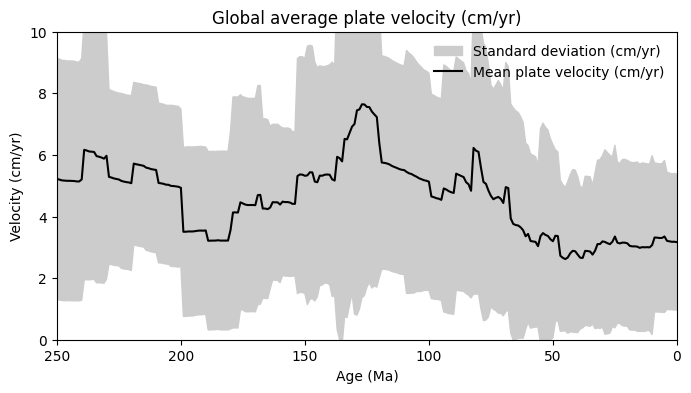

In [8]:

fig = plt.figure(figsize=(8, 4), dpi=100)
ax1 = fig.add_subplot(111, xlim=(250,0), ylim=(0,10), xlabel='Age (Ma)', ylabel="Velocity (cm/yr)",
                      title='Global average plate velocity (cm/yr)')

ax1.fill_between(time_range, vel_av-vel_std, vel_av+vel_std, color='0.8', label="Standard deviation (cm/yr)")
ax1.plot(time_range, vel_av, c='k', label="Mean plate velocity (cm/yr)")

ax1.legend(loc="upper right", frameon=False)
fig.savefig(
    os.path.join(
        "NotebookFiles",
        "average_plate_velocity.pdf",
    ),
    bbox_inches='tight',
)

### Visualising `Points` object velocity data: Scatterplot

We can visualise all the points on our velocity domain on a scatterplot - they will be colour mapped with their velocity magnitudes. We use matplotlib's `scatter` function for the scatterplot. It needs an array of latitudes and an array of longitudes to plot point data on. These will be __x and y__, the coordinates of points on our velocity domain feature. 

We plot the velocity domain feature points (in `x` and `y`) on a scatterplot below using their velocity magnitudes as a colour scale. 

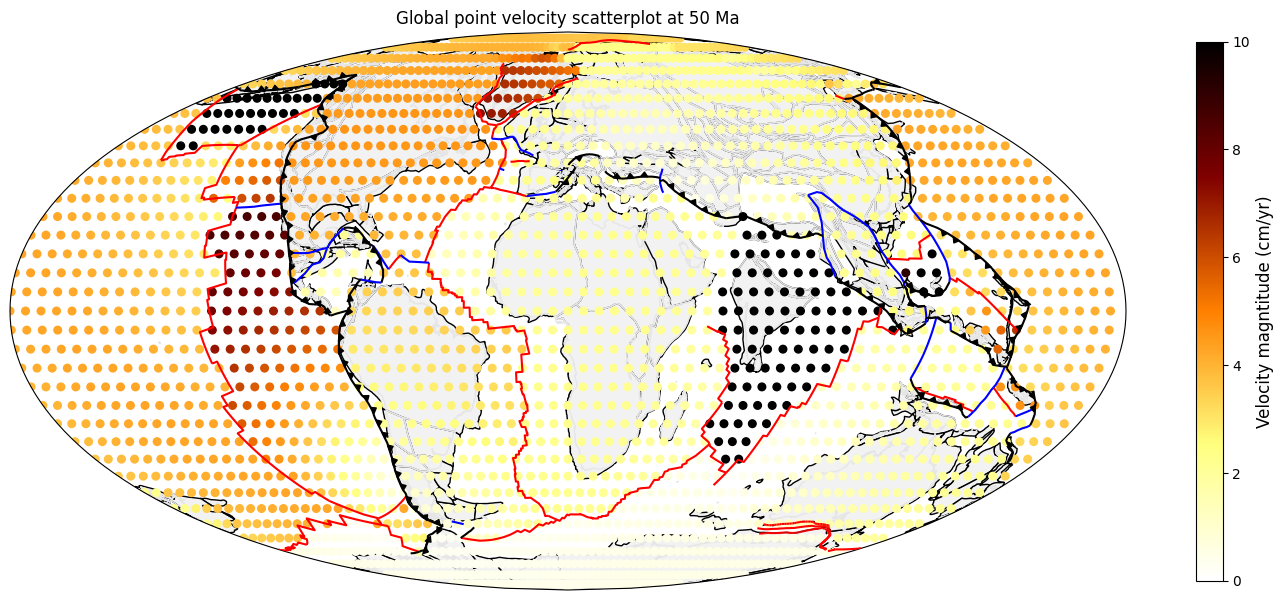

In [15]:
time = 50

# Set up a GeoAxis plot
fig = plt.figure(figsize=(18,14))
ax3 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
plt.title('Global point velocity scatterplot at %i Ma' % (time))

# Plot all topologies reconstructed to 50Ma
gplot.time = time # Ma
gplot.plot_continents(ax3, facecolor='0.95')
gplot.plot_coastlines(ax3, color='0.9')
gplot.plot_ridges(ax3, color='r', zorder=3)
gplot.plot_transforms(ax3, color='b', zorder=3)
gplot.plot_trenches(ax3, color='k', zorder=3)
gplot.plot_subduction_teeth(ax3, color='k', zorder=3)

vel_x, vel_y = gpts.plate_velocity(int(time))
vel_mag = np.hypot(vel_x, vel_y)
# Plot the velocity domain points with their velocity magnitudes as a colour scale.
im = ax3.scatter(x, y, transform=ccrs.PlateCarree(),c=vel_mag,s=30,cmap=plt.cm.afmhot_r,vmin=0,vmax=10, zorder=2)

# Add colorbar, set global extent and show plot
fig.colorbar(im, ax=ax3,shrink=0.5).set_label('Velocity magntitude (cm/yr)',fontsize=12)
ax3.set_global()
plt.show()

If you have [moviepy](https://moviepy.readthedocs.io/en/latest/install.html) installed, you can animate the motion of topological plates through geological time with a scatterplot of domain point velocities (in cm/yr) overlying the plates. Let's reconstruct plate movements from 0-100Ma in intervals of 10 Ma. With each iteration of the time loop we re-calculate velocity data.

In [10]:
def generate_frame(time, output_dir):
    # Get all point velocities and their magnitudes
    vel_x, vel_y = gpts.plate_velocity(int(time))
    vel_mag = np.hypot(vel_x, vel_y)
    
    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(18,14))
    ax3 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    plt.title('Global point velocity scatterplot at %i Ma' % (time))

    # Plot all topologies reconstructed to the current Ma
    gplot.time = time # Ma
    gplot.plot_continents(ax3, facecolor='0.95')
    gplot.plot_coastlines(ax3, color='0.9')
    gplot.plot_ridges(ax3, color='r', zorder=3)
    gplot.plot_transforms(ax3, color='b', zorder=3)
    gplot.plot_trenches(ax3, color='k', zorder=3)
    gplot.plot_subduction_teeth(ax3, color='k', zorder=3)

    # Plot the velocity domain points with their velocity magnitudes as a colour scale.
    im = ax3.scatter(x, y, transform=ccrs.PlateCarree(),c=vel_mag,s=30,cmap=plt.cm.afmhot_r,vmin=0,vmax=10,
                     zorder=2)

    # Add colorbar, set global extent and show plot
    fig.colorbar(im, ax=ax3,shrink=0.5).set_label('Velocity magntitude (cm/yr)',fontsize=12)
    ax3.set_global()
    fig.savefig(
        os.path.join(
            output_dir,
            "plate_velocity_scatter_plot_%d_Ma.png" % time,
        ),
        bbox_inches="tight",
    )
    plt.close(fig)
    
    print('Image for {} Ma saved'.format(time))

In [ ]:
try:
    import moviepy.editor as mpy

    mpy_available = True
except ImportError:
    mpy_available = False

if mpy_available:
    # Time variables
    oldest_seed_time = 100 # Ma
    time_step = 10 # Ma

    with tempfile.TemporaryDirectory() as tmpdir:
        # Create a plot for each 10 Ma interval
        for time in np.arange(oldest_seed_time,0.,-time_step):
            generate_frame(time, output_dir=tmpdir)

        # ------- CREATE THE MOVIE --------
        frame_list = []
        for time in np.arange(oldest_seed_time,0.,-time_step):
            frame_list.append(
                os.path.join(
                    tmpdir,
                    "plate_velocity_scatter_plot_%d_Ma.png" % time,
                )
            )

        clip = mpy.ImageSequenceClip(frame_list, fps=5)
        clip.write_gif(
            os.path.join(
                tmpdir,
                "plate_velocity_scatter_plot.gif",
            )
        )

        from IPython.display import Image
        print('The movie will show up in a few seconds. Please be patient...')
        with open(
            os.path.join(
                tmpdir,
                "plate_velocity_scatter_plot.gif",
            ),
            'rb',
        ) as f:
            display(Image(data=f.read(), format='gif', width = 2000, height = 1000))

## Plotting velocity vector arrow fields
As a first example, let's reconstruct all topological plates and boundaries to 50Ma and illustrate the velocity of each moving plate! One way to do this is by plotting a velocity vector field using the `plot_plate_motion_vectors` method on the `PlotTopologies` object.

Since `plot_plate_motion_vectors` uses Cartopy's `quiver` function, it accepts `quiver` keyword arguments like `regrid_shape`. This is useful if you'd like your vectors interpolated onto a regular grid in projection space.

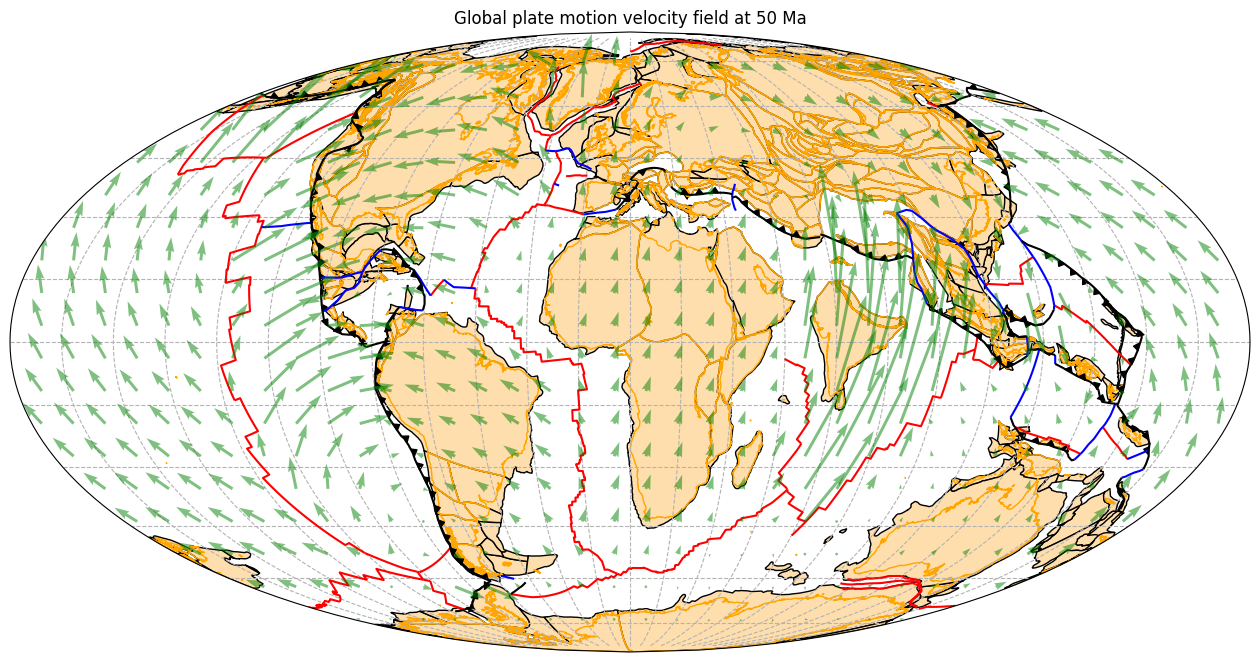

In [16]:
time = 50

# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax1.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Global plate motion velocity field at %i Ma' % (time))

# Plot all topologies
gplot.time=time
gplot.plot_continents(ax1, facecolor='navajowhite')
gplot.plot_coastlines(ax1, color='orange')
gplot.plot_ridges(ax1, color='r')
gplot.plot_transforms(ax1, color='b')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
ax1.set_global()

# Plot a veloctiy vector field on both maps
gplot.plot_plate_motion_vectors(ax1, regrid_shape=20, alpha=0.5, color='green', zorder=2)

## Plotting a velocity streamplot

We can visualise the same data with streamplot from matplotlib.

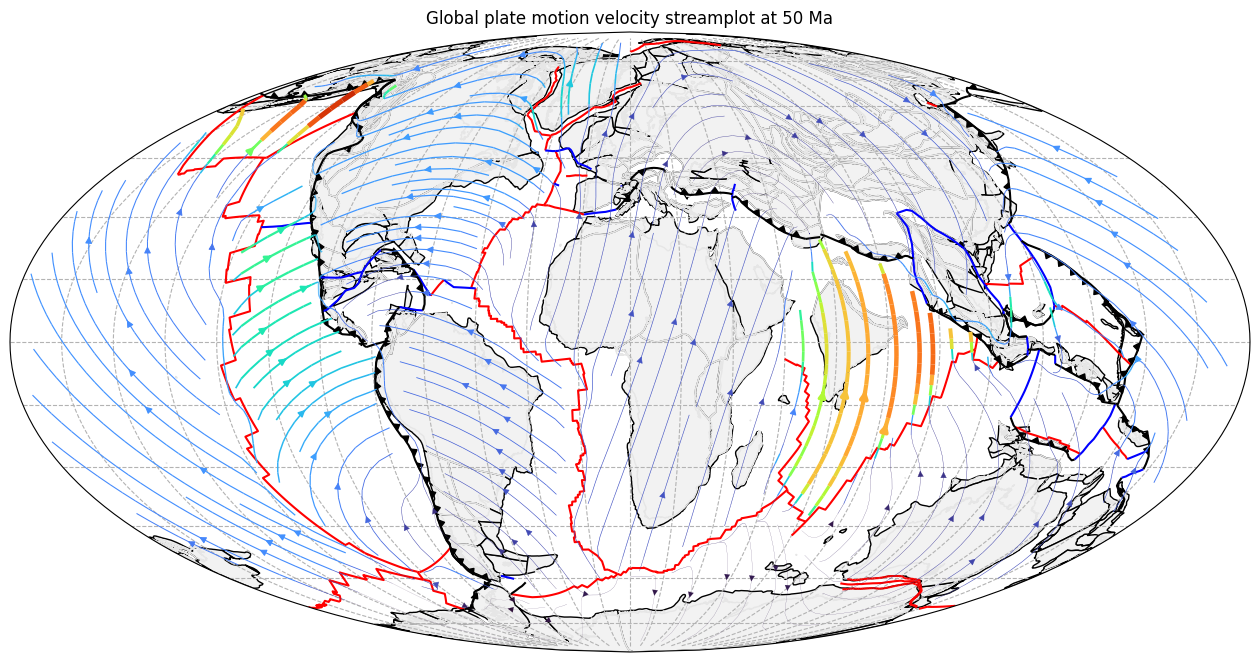

In [17]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax2 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax2.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Global plate motion velocity streamplot at %i Ma' % (time))

# Plot all topologies
gplot.time = time # Ma
gplot.plot_continents(ax2, facecolor='0.95')
gplot.plot_coastlines(ax2, color='0.9')
gplot.plot_ridges(ax2, color='r')
gplot.plot_transforms(ax2, color='b')
gplot.plot_trenches(ax2, color='k')
gplot.plot_subduction_teeth(ax2, color='k')
ax2.set_global()

vel_x, vel_y = gpts.plate_velocity(int(time))
vel_x *= 10
vel_y *= 10
vel_mag = np.hypot(vel_x, vel_y)

ax2.streamplot(gpts.lons, gpts.lats, vel_x, vel_y, color=vel_mag, transform=ccrs.PlateCarree(), 
                   linewidth=0.02*vel_mag, cmap=plt.cm.turbo, density=2)

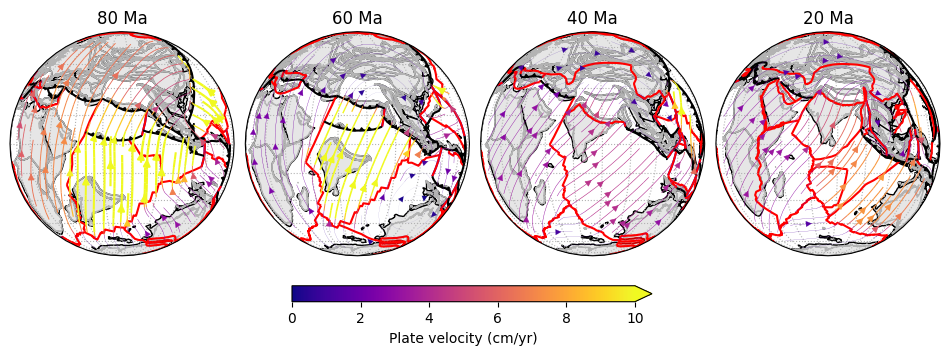

In [18]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(12,4))
norm = Normalize(0, 10)

for i, time in enumerate([80, 60, 40, 20]):
    ax2 = fig.add_subplot(1,4,i+1, projection=ccrs.Orthographic(70, 0), title='{:.0f} Ma'.format(time))
    ax2.set_global()
    ax2.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    # plt.title('Global plate motion velocity streamplot at %i Ma' % (time))

#     gplot.plot_grid(ax2, rgb)

    # Plot  topologies
    gplot.time = time # Ma
    gplot.plot_continents(ax2, facecolor='0.9')
    gplot.plot_coastlines(ax2, color='0.7')
    gplot.plot_ridges(ax2, color='r')
    gplot.plot_transforms(ax2, color='b')
    gplot.plot_misc_boundaries(ax2, color='r')
    gplot.plot_trenches(ax2, color='k')
    gplot.plot_subduction_teeth(ax2, color='k')

    vel_x, vel_y = gpts.plate_velocity(int(time))
    vel_x *= 10
    vel_y *= 10
    vel_mag = np.hypot(vel_x, vel_y)

    sp = ax2.streamplot(gpts.lons, gpts.lats, vel_x, vel_y, color=vel_mag*0.1, transform=ccrs.PlateCarree(), 
                   norm=norm, linewidth=0.01*vel_mag, cmap='plasma', density=1)
    
fig.subplots_adjust(wspace=0.05)

cax = plt.axes([0.36,0.1, 0.3, 0.04])
fig.colorbar(sp.lines, cax=cax, orientation='horizontal', label='Plate velocity (cm/yr)', extend='max')

fig.savefig(
    os.path.join(
        "NotebookFiles",
        "India_collision.pdf",
    ),
    bbox_inches='tight',
)

If you have [moviepy](https://moviepy.readthedocs.io/en/latest/install.html) installed, you can animate the motion of topological plates through geological time with a streamplot of domain point velocities (in cm/yr) overlying the plates. Let's reconstruct plate movements over 100 Ma in intervals of 10 Ma. 

In [15]:
def generate_frame(time, output_dir):
    vel_x, vel_y = gpts.plate_velocity(int(time))
    vel_x *= 10
    vel_y *= 10
    vel_mag = np.hypot(vel_x, vel_y)

    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(16,12))
    ax2 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    ax2.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    plt.title('Global plate motion velocity streamplot at %i Ma' % (time))

    # Reconstruct topological plates and boundaries with PlotTopologies
    gplot.time = time # Ma
    gplot.plot_continents(ax2, facecolor='0.95')
    gplot.plot_coastlines(ax2, color='0.9')
    gplot.plot_ridges(ax2, color='r')
    gplot.plot_transforms(ax2, color='b')
    gplot.plot_trenches(ax2, color='k')
    gplot.plot_subduction_teeth(ax2, color='k')
    ax2.set_global()

    # Create the streamplot, using speed as a colormap.
    ax2.streamplot(gpts.lons, gpts.lats, vel_x, vel_y, color=vel_mag, transform=ccrs.PlateCarree(), 
                       linewidth=0.02*vel_mag, cmap=plt.cm.turbo, density=2)

    fig.savefig(
        os.path.join(
            output_dir,
            "plate_velocity_stream_plot_%d_Ma.png" % time,
        ),
        bbox_inches="tight",
    )
    plt.close(fig)
    
    print('Image for %d Ma saved' % time)

In [ ]:
if mpy_available:
    # Time variables
    oldest_seed_time = 100 # Ma
    time_step = 10 # Ma

    with tempfile.TemporaryDirectory() as tmpdir:
        # Create a plot for each 10 Ma interval
        for time in np.arange(oldest_seed_time,0.,-time_step):
            generate_frame(time, output_dir=tmpdir)

        frame_list = []
        for time in np.arange(oldest_seed_time,0.,-time_step):
            frame_list.append(
                os.path.join(
                    tmpdir,
                    "plate_velocity_stream_plot_%d_Ma.png" % time,
                )
            )

        clip = mpy.ImageSequenceClip(frame_list, fps=5)
        clip.write_gif(
            os.path.join(
                tmpdir,
                "plate_velocity_stream_plot.gif",
            )
        )

        print('The movie will show up in a few seconds. Please be patient...')
        with open(
            os.path.join(
                tmpdir,
                "plate_velocity_stream_plot.gif",
            ),
            "rb",
        ) as f:
            display(Image(data=f.read(), format='gif', width = 3000, height = 1000))